In [1]:
import sys
sys.path.append('/jet/home/cpestell/lab3-1')
from ridge_utils.DataSequence import DataSequence


ModuleNotFoundError: No module named 'ridge_utils'

In [1]:
import sys
sys.path.append('..') 
from ridge_utils.DataSequence import DataSequence
import torch
import pickle
import os
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from encoder import Encoder
from data import TextDataset
from train_encoder import train_bert

# Train Encoder

Loaded 109 podcast stories
Training
Epoch [1/1], Loss: 2.9801


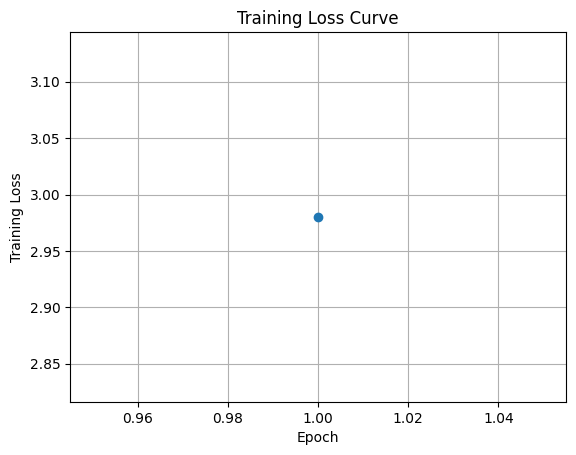

Pretrained encoder saved as pretrained_encoder.pt


In [2]:
# Load the podcast text data
data_path = "/ocean/projects/mth240012p/shared/data"
raw_text_path = os.path.join(data_path, "raw_text.pkl")

with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

print(f"Loaded {len(raw_text)} podcast stories")

# Flatten all the words from all stories into a single list
all_sentences = []
for story in raw_text.values():
    all_sentences.extend(story.data)

# Tokenizer & Dataset
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = TextDataset(all_sentences, tokenizer, max_len=32)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create encoder model
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = Encoder(vocab_size=tokenizer.vocab_size)
encoder = encoder.to(device)

# Train the model using masked language modeling
print("Training")
train_bert(
    model=encoder,
    dataloader=dataloader,
    tokenizer=tokenizer,
    epochs=1, # we can change this 
    lr=5e-4, # same as well 
    device=device
)

# Save pretrained encoder weights
torch.save(encoder.state_dict(), "pretrained_encoder.pt")
print("Pretrained encoder saved as pretrained_encoder.pt")

# Generate All Embeddings 

In [3]:
import torch
import numpy as np
import pickle, os
from transformers import BertTokenizerFast
from encoder import Encoder
from preprocessing import downsample_word_vectors, make_delayed

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
# tokenizer = BertTokenizerFast.from_pretrained("/jet/home/cpestell/bert-base-uncased")  # your local copy
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

encoder = Encoder(vocab_size=tokenizer.vocab_size)
encoder.load_state_dict(torch.load("pretrained_encoder.pt", map_location=device))
encoder.to(device)
encoder.eval()

# Load raw text
data_path = "/ocean/projects/mth240012p/shared/data"
with open(os.path.join(data_path, "raw_text.pkl"), "rb") as f:
    raw_text = pickle.load(f)

story_names = list(raw_text.keys())

# Step 1: Generate encoder embeddings
encoder_vectors = {}
for story in story_names:
    words = raw_text[story].data
    inputs = tokenizer(words, padding=True, truncation=True, return_tensors="pt", max_length=64)

    input_ids = inputs["input_ids"].to(device)
    token_type_ids = inputs["token_type_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        hidden = encoder(input_ids, token_type_ids, attention_mask)

    # Mean over tokens (seq_len)
    sentence_embeddings = hidden.mean(dim=1).cpu().numpy()
    encoder_vectors[story] = sentence_embeddings
    print(f"{story}: Encoder shape = {encoder_vectors[story].shape}")

# Step 2: Downsample
wordseqs = raw_text
downsampled_encoder = downsample_word_vectors(story_names, encoder_vectors, wordseqs)

# Step 3: Trim
X_encoder_trimmed = {}
for story in downsampled_encoder:
    X_encoder_trimmed[story] = downsampled_encoder[story][5:-10, :]
    print(f"Trimmed shape for {story}:", X_encoder_trimmed[story].shape)

# Step 4: Create lagged features
X_encoder_lagged = {}
for story in X_encoder_trimmed:
    X_encoder_lagged[story] = make_delayed(X_encoder_trimmed[story], delays=range(1, 5))
    # print(f"Lagged shape for {story}:", X_encoder_lagged[story].shape)


sweetaspie: Encoder shape = (697, 256)
thatthingonmyarm: Encoder shape = (2073, 256)
tildeath: Encoder shape = (2297, 256)
indianapolis: Encoder shape = (1554, 256)
lawsthatchokecreativity: Encoder shape = (2084, 256)
golfclubbing: Encoder shape = (1211, 256)
jugglingandjesus: Encoder shape = (887, 256)
shoppinginchina: Encoder shape = (1731, 256)
cocoonoflove: Encoder shape = (1984, 256)
hangtime: Encoder shape = (1927, 256)
beneaththemushroomcloud: Encoder shape = (1916, 256)
dialogue4: Encoder shape = (1692, 256)
thepostmanalwayscalls: Encoder shape = (2220, 256)
stumblinginthedark: Encoder shape = (2681, 256)
kiksuya: Encoder shape = (1699, 256)
haveyoumethimyet: Encoder shape = (2985, 256)
theinterview: Encoder shape = (1079, 256)
againstthewind: Encoder shape = (838, 256)
tetris: Encoder shape = (1350, 256)
canplanetearthfeedtenbillionpeoplepart2: Encoder shape = (2532, 256)
alternateithicatom: Encoder shape = (2174, 256)
goldiethegoldfish: Encoder shape = (1680, 256)
seedpotatoe

# Modelling and Evaluation

Missing Y file for: myfirstdaywiththeyankees
Missing Y file for: dialogue6
Missing Y file for: dialogue5
Missing Y file for: dialogue3
Missing Y file for: dialogue2
X_train: (28644, 1024)
Y_train: (28644, 94251)
Cross-validation scores: [-1.00108259 -1.00146883 -0.95189501 -0.99805991 -0.96588417]
Mean cross-validation score: -0.9837
Missing Y file for: dialogue1
Missing Y file for: dialogue4
Missing Y file for: onlyonewaytofindout
Mean CC: 0.0082
Median CC: 0.0079
Top 1% CC: 0.0460
Top 5% CC: 0.0332


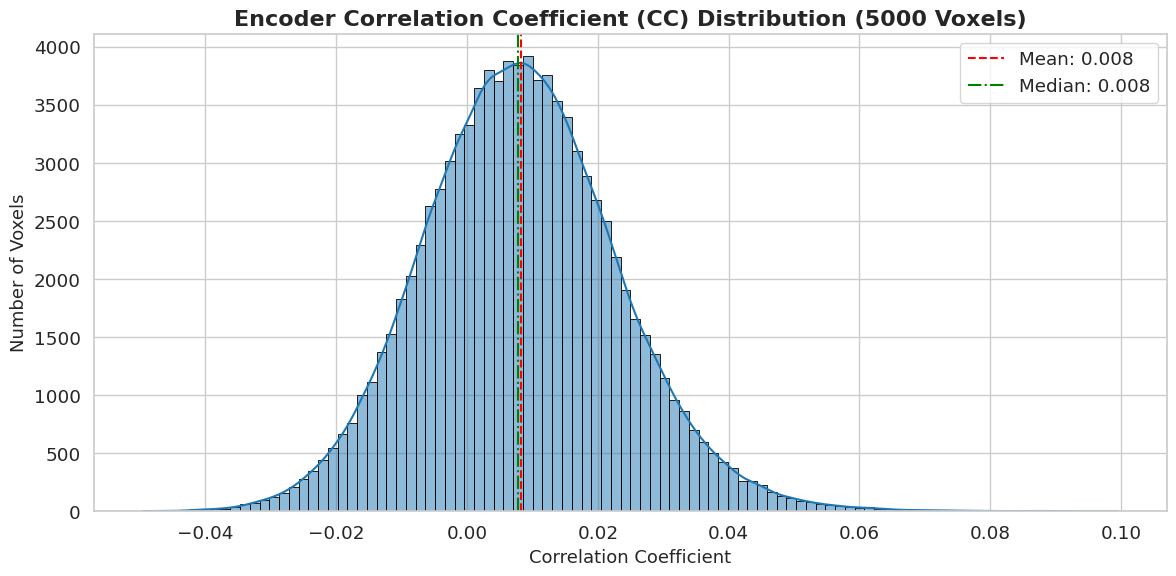

Plot saved to: ../results/cc_distribution_encoder_subject2_5000vox.png


In [6]:
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Setup ---------
story_names = list(raw_text.keys())
train_stories, test_stories = train_test_split(story_names, test_size=0.2, random_state=42)

subject2_path = os.path.join(data_path, "subject2")
X_train = []
Y_train = []



for story in train_stories:
    if story in X_encoder_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_encoder_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_train.append(X[:min_len])
            Y_train.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

# --------- Clean NaNs ---------
mask = ~np.isnan(Y_train).any(axis=1)
X_train_clean = X_train[mask]
Y_train_clean = Y_train[mask]

# --------- Cross Validation ---------
ridge = Ridge(alpha=100.0)
cv_scores = cross_val_score(ridge, X_train_clean, Y_train_clean, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.4f}")

# --------- Train Model ---------
ridge.fit(X_train_clean, Y_train_clean)

# --------- Evaluate on Test Set ---------
X_test = []
Y_test = []

for story in test_stories:
    if story in X_encoder_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_encoder_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_test.append(X[:min_len])
            Y_test.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_test = np.vstack(X_test)
Y_test = np.vstack(Y_test)

# Clean NaNs from test
mask = ~np.isnan(Y_test).any(axis=1)
X_test_clean = X_test[mask]
Y_test_clean = Y_test[mask]

# Predict
Y_pred = ridge.predict(X_test_clean)

# --------- Compute Correlation Coefficients (CCs) ---------
def compute_voxel_ccs(y_true, y_pred):
    ccs = []
    for i in range(y_true.shape[1]):
        try:
            cc, _ = pearsonr(y_true[:, i], y_pred[:, i])
        except:
            cc = np.nan
        ccs.append(cc)
    return np.array(ccs)

ccs_encoder = compute_voxel_ccs(Y_test_clean, Y_pred)

print(f"Mean CC: {np.mean(ccs_encoder):.4f}")
print(f"Median CC: {np.median(ccs_encoder):.4f}")
print(f"Top 1% CC: {np.percentile(ccs_encoder, 99):.4f}")
print(f"Top 5% CC: {np.percentile(ccs_encoder, 95):.4f}")

# --------- Visualization ---------
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

sns.histplot(ccs_encoder[~np.isnan(ccs_encoder)], bins=100, kde=True, color="#1f77b4", edgecolor="black", stat="count")
plt.axvline(np.mean(ccs_encoder), color='red', linestyle='--', label=f"Mean: {np.mean(ccs_encoder):.3f}")
plt.axvline(np.median(ccs_encoder), color='green', linestyle='-.', label=f"Median: {np.median(ccs_encoder):.3f}")
plt.title("Encoder Correlation Coefficient (CC) Distribution (5000 Voxels)", fontsize=16, weight="bold")
plt.xlabel("Correlation Coefficient", fontsize=13)
plt.ylabel("Number of Voxels", fontsize=13)
plt.legend()
plt.tight_layout()

# Save plot
save_dir = os.path.join("..", "results")
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, "cc_distribution_encoder_subject2_5000vox.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"Plot saved to: {plot_path}")
